# Welcome

This notebook serves as an example to how we can determine the internal accessibility of neighbourhoods in relation to Low Traffic Neighbourhoods. Any issues, please contact me at b8008458@newcastle.ac.uk!

We begin with importing the necessary libraries. There should be a .yml file on the GitHub repository which can be used to set up the correct environment. We also update OSMNx to ensure all the OSM tags we need are avaiable and ready. 

In [1]:
# Library imports
import geopandas as gpd
import osmnx as ox
import networkx as nx
import momepy
import matplotlib.pyplot as plt
import folium
import pandas as pd
import overpy
from shapely.geometry import LineString
from shapely.geometry import Point
import requests
from shapely.geometry import MultiPolygon
from shapely.geometry import Polygon
import statistics
from shapely.ops import unary_union
import random

c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We can now import the neighbourhoods that we are going to use in this analysis. You can use your own neighbourhood boundaries if you have them. We will use the ones created in the previous notebook. We also need to set our study area boundary:

In [7]:
# set place
place = "Newcastle Upon Tyne, United Kingdom"

In [2]:
# Path to your GeoPackage file
file_path = r'C:\Users\b8008458\Documents\scratch_space\neighbourhoods.gpkg'

In [ ]:
# Read GeoPackage 
neighbourhoods = gpd.read_file(file_path, driver="GPKG")

# check neighbourhoods are correct by viewing them on a map:
neighbourhoods.explore()

In [8]:
# boundary
boundary = ox.geocode_to_gdf(place)
boundary = boundary.to_crs('EPSG:27700')

# buffer boundary to ensure clips include riverlines which may act as borders between geographies
boundary_buffered = boundary.buffer(50)

We need the walking, driving and complete street networks for this section of analysis. We use OpenStreetMap data for our street networks. The common nodes between the walking and driving networks are found to ensure we have viable origins and destiniations for our accessiablity analysis. There is also a final cleaning of the the neighbourhoods to ensure that we can assess the neighbourhood accessiablity of all areas.

In [9]:
## get street networks for walking and driving

# reset boundary_buffered crs for passing to OSM
boundary_buffered_4326 = boundary_buffered.to_crs('4326')

# get street networks

all_streets = ox.graph_from_polygon(boundary_buffered_4326.geometry.iloc[0], network_type='all', simplify=False)
walk_streets = ox.graph_from_polygon(boundary_buffered_4326.geometry.iloc[0], network_type='walk', simplify=True)
drive_streets = ox.graph_from_polygon(boundary_buffered_4326.geometry.iloc[0], network_type='drive', simplify=False)

all_edges = ox.graph_to_gdfs(all_streets, nodes=False, edges=True)
all_nodes = ox.graph_to_gdfs(all_streets, nodes=True, edges=False)

walk_edges = ox.graph_to_gdfs(walk_streets, nodes=False, edges=True)
walk_nodes = ox.graph_to_gdfs(walk_streets, nodes=True, edges=False)

drive_edges = ox.graph_to_gdfs(drive_streets, nodes=False, edges=True)
drive_nodes = ox.graph_to_gdfs(drive_streets, nodes=True, edges=False)


## find the common nodes between networks 

# this ensures that shortest paths between points should always be able to be calculated
common_nodes = drive_nodes.merge(walk_nodes, on='osmid', suffixes=('_drive', '_walk'))
common_nodes_gdf = gpd.GeoDataFrame(common_nodes, geometry='geometry_drive')
common_nodes_gdf.explore()



## filter neighbourhoods to only locations with more than 1 intersection (1 or fewer intersections indicates that all travel modes will be the same)

# reset neighbourhoods crs
neighbourhoods = neighbourhoods.to_crs('4326')

# Spatial join to count points within each neighborhood
spatial_join = gpd.sjoin(neighbourhoods, common_nodes_gdf, how='left', op='contains')

# Group by 'ID' and count the points within each neighborhood
point_counts = spatial_join.groupby('ID').size().reset_index(name='point_count')

# Filter out neighborhoods with 1 or 0 points
filtered_neighbourhood_ids = point_counts[point_counts['point_count'] > 1]['ID']

neighbourhoods= neighbourhoods[neighbourhoods['ID'].isin(filtered_neighbourhood_ids)]


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


To measure the accessiablity of a neighbourhood, we compare the shortest path distances of walking against driving. The shortest distances are found in this example between 5 random nodes within each neighbourhood to 5 other random common nodes within each respective neighbourhood. In more detailed analysis, a greater number of nodes should be used. This provides a measure of permiablity within the neighbourhood. A large differance in shortest path distance indicates high permiablity for walking, and therefore a LTN is more likely.

In [ ]:
## random to random for shortest distance calculations

# begin function 
def calculate_distance_stats_from_points(points_gdf, network):
    all_pairs_shortest_paths = {}
    points_osmids = points_gdf.index.tolist()  # Assuming the 'osmid' is the index in the GeoDataFrame

    if len(points_osmids) <= 5:
        # If there are less than 5 nodes, calculate all to all
        for start_node in points_osmids:
            shortest_paths = {}
            try:
                for end_node in points_osmids:
                    if start_node != end_node:
                        distance = nx.shortest_path_length(network, start_node, end_node, weight='length')
                        shortest_paths[end_node] = distance
                all_pairs_shortest_paths[start_node] = shortest_paths
            except nx.NetworkXNoPath:
                # If no path is found, continue to the next iteration
                continue
    else:
        # Randomly select 5 nodes for both start and end
        start_nodes = random.sample(points_osmids, 5)
        end_nodes = random.sample(points_osmids, 5)

        for start_node in start_nodes:
            shortest_paths = {}
            try:
                for end_node in end_nodes:
                    if start_node != end_node:
                        distance = nx.shortest_path_length(network, start_node, end_node, weight='length')
                        shortest_paths[end_node] = distance
                all_pairs_shortest_paths[start_node] = shortest_paths

            except nx.NetworkXNoPath:
                # If no path is found, continue to the next iteration
                continue

    distances = [length for paths in all_pairs_shortest_paths.values() for length in paths.values()]

    mean_distance = statistics.mean(distances)
    median_distance = statistics.median(distances)
    min_distance = min(distances)
    max_distance = max(distances)
    distance_range = max_distance - min_distance
    total_distance = sum(distances)

    return {
        "mean_distance": mean_distance,
        "median_distance": median_distance,
        "min_distance": min_distance,
        "max_distance": max_distance,
        "distance_range": distance_range,
        "total_distance": total_distance
    }

results = []

for index, row in neighbourhoods.iterrows():
    neighbourhood = neighbourhoods.loc[[index]]
    print("Starting index number", index)

    ## get neighbourhood boundary and neighbourhood boundary buffer
    # set crs
    neighbourhood = neighbourhood.to_crs('27700')
    # create a buffer neighbourhood
    neighbourhood_buffer = neighbourhood['geometry'].buffer(15)
    # convert back to a geodataframe (for later on)
    neighbourhood_buffer = gpd.GeoDataFrame(geometry=neighbourhood_buffer)
    # reset crs
    neighbourhood, neighbourhood_buffer = neighbourhood.to_crs('4326'), neighbourhood_buffer.to_crs('4326')


    ## get nodes which can be driven to and walked to within area
    neighbourhood_nodes = gpd.clip(common_nodes_gdf, neighbourhood_buffer)

    ## get length of total edges within the neighbourhood
    edges_within_neighbourhood = gpd.sjoin(all_edges, neighbourhood, how="inner", op="intersects")
    total_length = edges_within_neighbourhood['length'].sum()


    ## calculate neighbourhood distance stats for walking and driving
    walk_stats = calculate_distance_stats_from_points(neighbourhood_nodes, walk_streets)
    drive_stats = calculate_distance_stats_from_points(neighbourhood_nodes, drive_streets)


    ## Add the statistics to the GeoDataFrame
    neighbourhood['walk_mean_distance'] = walk_stats['mean_distance']
    neighbourhood['walk_median_distance'] = walk_stats['median_distance']
    neighbourhood['walk_min_distance'] = walk_stats['min_distance']
    neighbourhood['walk_max_distance'] = walk_stats['max_distance']
    neighbourhood['walk_distance_range'] = walk_stats['distance_range']
    neighbourhood['walk_total_distance'] = walk_stats['total_distance']

    neighbourhood['drive_mean_distance'] = drive_stats['mean_distance']
    neighbourhood['drive_median_distance'] = drive_stats['median_distance']
    neighbourhood['drive_min_distance'] = drive_stats['min_distance']
    neighbourhood['drive_max_distance'] = drive_stats['max_distance']
    neighbourhood['drive_distance_range'] = drive_stats['distance_range']
    neighbourhood['drive_total_distance'] = drive_stats['total_distance']

    ## Store statistics along with neighborhood ID or other identifying information
    result = {
        'neighbourhood_id': neighbourhood['ID'].iloc[0],  # Assuming you have an ID column
        'walk_mean_distance': walk_stats['mean_distance'],
        'walk_median_distance': walk_stats['median_distance'],
        'walk_total_distance': walk_stats['total_distance'],
        

        'drive_mean_distance': drive_stats['mean_distance'],
        'drive_median_distance': drive_stats['median_distance'],
        'drive_total_distance': drive_stats['total_distance'],

        'total_edge_length': total_length
    }

    print("Polygon", index, "processed, moving to next")
    results.append(result)

## Convert the results to a new dataframe
results_df = pd.DataFrame(results)


 

With the distances calculated, we can now calculate the differances in distance and create maps of our results:

In [17]:
## calculate differances

results_df['mean_distance_diff'] = results_df['walk_mean_distance'] - results_df['drive_mean_distance']
results_df['median_distance_diff'] = results_df['walk_median_distance'] - results_df['drive_median_distance']
results_df['total_distance_diff'] = results_df['walk_total_distance'] - results_df['drive_total_distance']


# merge into results_gdf
merged_df = pd.merge(neighbourhoods, results_df, left_on = "ID", right_on = "neighbourhood_id")
results_gdf = gpd.GeoDataFrame(merged_df, geometry='geometry')


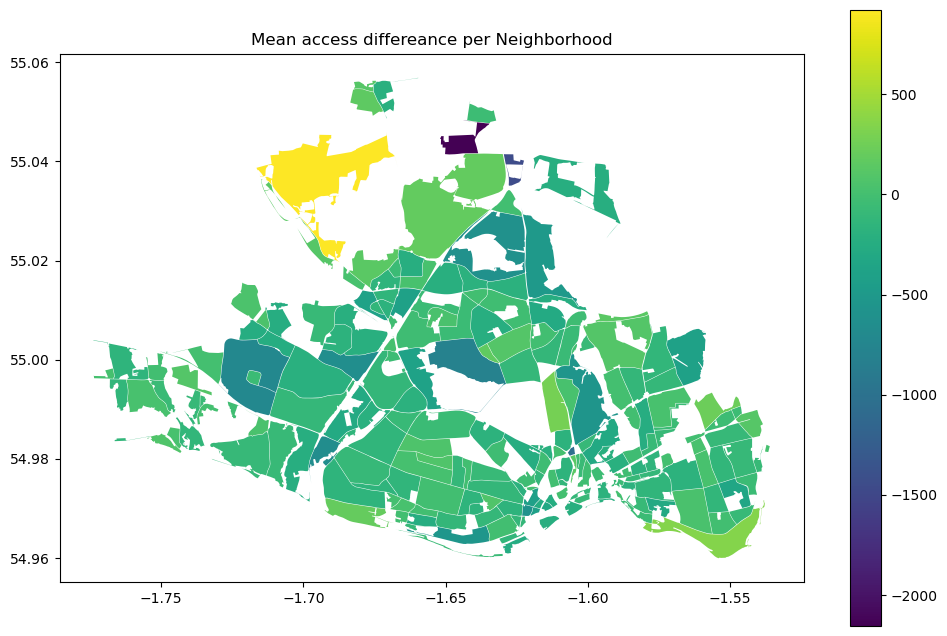

In [19]:
# Plot the map of total filter types
results_gdf.plot(column='mean_distance_diff', cmap='viridis', legend=True, figsize=(12, 8))
plt.title('Mean access differeance (meters) per Neighborhood')
plt.show()